In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Transformation et manipulation des données<br>
    </h1>
    MovieLens - Préparation des données pour système de recommandations de films.<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A56<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommandations de films. Elle contient plus de 100 000 notations représentant plus de 9 700 films. Ces notations ont été établi par plus de 600 utilisateurs entre mars 1996 et septembre 2018. Elle contient également les métadonnées sur 19 genres. Les données sont structurées dans 4 fichiers distincts.

<br>**tags.csv**

Fichier contenant les tags (quelques mots générés par les utilisateurs) de chaque film. Ces données ne sont pas utilisées dans ce projet afin d'en réduire la portée.

<br>**links.csv**

Fichier contenant les métadonnées permettant de lier un film à d'autres sources de données. Chaque ligne a ce format :

<div class="indentation">
<div class="fixblock">movieId, imdbId, tmdbId</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|tmdbId| Identifiant du film dans [The Movie DB](https://www.themoviedb.org).|    
</div>

<br>**movies.csv**

Ce fichier contient les métadonnées de chaque film. Chaque ligne a ce format :

<div class="indentation">
<div class="fixblock">movieId, title, genres</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|title| Titre du film. Peut contenir l'année de parution.|
|genres| Genres. Liste de mots séparés par un 'pipe' (\|). |
</div>

<br>**ratings.csv**

Ce fichier contient les notations. Chaque ligne a ce format :

<div class="indentation">
<div class="fixblock">userId, movieId, rating, timestamp</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur dans cette base de données.|
|movieId| Identifiant du film dans cette base de données.|
|rating| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. |
|timestamp| Date à laquelle la note a été entrée. Encodée dans le format [UTC](https://tinyurl.com/32e6a5pc).|
</div>

<br>

L'objectif de ce projet est de préparer les données pour un éventuel système de recommantations de films. Nous allons examiner chaque fichier indépendamment et utiliser le web scraping pour corriger, dans la mesure du possible, les informations manquantes. Nous allons transformer les variables des diverses bases de données et en créer de nouvelles. Nous allons sauvegarder tout notre prétraitement dans 2 nouveaux fichiers. Finalement, nous allons proposer quelques méthodes d'apprentissage qui pourraient servir à une implémentation du système.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time

from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from tqdm.notebook import tqdm

#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.dataset.MovieLens as mvl
import helpers.WebScraping as scrap
import helpers.jupyter as jup

# Obtenir la base de données

Notre approche se veut la plus automatisée possible. Nous avons donc construit plusieurs modules python permettant de configurer et de rendre transparent nos processus. Nous faisons référence à [config_overrides.json](./config_overrides.json) et [helpers](./helpers) pour obtenir plus de détails.

In [3]:
#
# parametres configurant nos traitements
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset
#
mvl_dataset = mvl.load(configs.dataset)

  0%|          | 0/978202 [00:00<?, ?it/s]

Unziping dataset/ml-latest-small.zip


# links.csv
    
Les informations contenues dans ce fichier serviront pour le web scraping. Il donc important d'en faire un survol rapide.

In [4]:
print("Links:", mvl_dataset.links.shape)
print("Head")
display(mvl_dataset.links.head())
clstr.show_types(mvl_dataset.links)
clstr.show_na(mvl_dataset.links);

Links: (9742, 3)
Head


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


Types


,movieId,imdbId,tmdbId
Type,int64,object,object


Valeur manquante 8 (0.1%)


,movieId,imdbId,tmdbId
624,791,0113610,NaN
843,1107,0102336,NaN
2141,2851,0081454,NaN
3027,4051,0056600,NaN
5532,26587,0092337,NaN
5854,32600,0377059,NaN
6059,40697,0105946,NaN
7382,79299,0874957,NaN


* 9 742 individus
* 3 variables (elles correspondent bien à la description)
* Les types sont **objet** pour imdbId et tmdbId à cause de leur nature. Noter les doubles zéros (00) dans **imdbId**. Cette transformation est faite par les modules python et non montrée dans ce notebook. **movieId** est numérique mais sert tout de même d'identifiant.
* Il manque quelques liens sur [TMDB](https://www.themoviedb.org/). Les liens [IMDB](https://www.imdb.com/) seront par conséquent utilisés.

In [5]:
print("Vérifier doublons")
print("Avant:", mvl_dataset.links.shape)
mvl_dataset.links.drop_duplicates(inplace=True)
print("Après:", mvl_dataset.links.shape)

Vérifier doublons
Avant: (9742, 3)
Après: (9742, 3)


Aucun doublon trouvé. Les valeurs aberrantes (*outliers*) ne sont pas adressées étant donné la nature du fichier et que nous avons l'information qui nous intéresse.

# movies.csv

In [6]:
print("Movies:", mvl_dataset.movies.shape)
print("Head")
display(mvl_dataset.movies.head())
clstr.show_types(mvl_dataset.movies)
clstr.show_na(mvl_dataset.movies);

Movies: (9742, 3)
Head


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Types


,movieId,title,genres
Type,int64,object,object


Valeur manquante 0 (0.0%)


* 9 742 individus
* 3 variables (elles correspondent bien à la description)
* **title** et **genres** sont qualitatifs, **movieId** est numérique.
* Noter que **genres** est "multimodal"; il peut prendre simultanément N modalités.
* Aucune valeur manquante.

In [7]:
#
# validation doublons
#
print("Vérifier doublons")
print("Avant:", mvl_dataset.movies.shape)
mvl_dataset.movies.drop_duplicates(inplace=True)
print("Après:", mvl_dataset.movies.shape)

Vérifier doublons
Avant: (9742, 3)
Après: (9742, 3)


Aucun doublon trouvé. Tel que décrit plus haut, **title** contient l'année de parution. Nous allons l'extraire afin d'obtenir une nouvelle variable. Nous allons aussi tenter de l'enlever du titre.

In [8]:
def split_title_year(title, regex):
    x = regex.search(title)
    if x:
        title = x.group(1)
        year = x.group(2)
        year = int(year) if year else pd.NA
    else:
        year = pd.NA
    
    return pd.Series({"title": title, "year": year})

title_year_re = re.compile(configs.dataset.title_regex, flags=0)        
title_year = mvl_dataset.movies.title.apply(split_title_year, args=(title_year_re,))

#
# validation de l'extraction
#
print("Informations extraites:", title_year.shape)
print("Head")
display(title_year.head())
clstr.show_na(title_year);

Informations extraites: (9742, 2)
Head


,title,year
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995


Valeur manquante 12 (0.1%)


,title,year
6059,Babylon 5,<NA>
9031,Ready Player One,<NA>
9091,Hyena Road,<NA>
9138,The Adventures of Sherlock Holmes and Doctor W...,<NA>
9179,Nocturnal Animals,<NA>
9259,Paterson,<NA>
9367,Moonlight,<NA>
9448,The OA,<NA>
9514,Cosmos,<NA>
9515,Maria Bamford: Old Baby,<NA>


Il manque quelques années de parution. Il est probablement possible de les fixer en utilisant **links.imdbId** avec le web scraping.

In [9]:
def imdb_scap_year(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
        date_published = scrap.get_nested_property(imdb_json, ["datePublished"])
        if not success and date_published:
            date_published = pd.to_datetime(date_published)
            year = date_published.year
            success = True

        imdb_info = bs.find("script", attrs={"type": "application/json"})
        imdb_json = json.loads(imdb_info.text)
        releaseYear = scrap.get_nested_property(imdb_json, 
                                                ["props", 
                                                 "pageProps", 
                                                 "mainColumnData", 
                                                 "releaseYear",
                                                 "year"])
        if not success and releaseYear:
            year = releaseYear
            success = True

    if success:
        return (index, year, response.url)
    else:
        return (index, None, response.url)

def imdb_scap_year_apply_results(final_results):
    for index, year, url in final_results:
        if year is None:
            print(url, title_year.title[index], "Failed")
        else:
            title_year.year[index] = year

#    
# corriger year via web scraping avec imdb
#
year_na = title_year.year.isna()
year_link = mvl_dataset.links.imdbId[ year_na ]

if year_link.shape[0] > 0:
    with hlp.Profile() as year_profile:
        # par souci de temps d'iteration, nous avons parallelise les requetes
        results = scrap.imdb_requests_parallel(year_link,
                                               configs.web_scraping,
                                               imdb_scap_year,
                                               executor=configs.executor)
        imdb_scap_year_apply_results(results)
    print(f"Web scraping year: {year_profile.round_duration(2)}s")

# validation du scraping
clstr.show_na(title_year);

  0%|          | 0/12 [00:00<?, ?it/s]

Web scraping year: 5.17s
Valeur manquante 0 (0.0%)


In [10]:
#
# mettre a jour movies
#
mvl_dataset.movies["year"] = title_year.year.astype(np.int64)

Nous avons réussi à obtenir toutes les années. Nous devons inspecter l'effet de son retrait de **title**.

In [11]:
#
# validation effet extraction de l'annee de title
#
imdb_ids = mvl_dataset.links.imdbId[mvl_dataset.links.movieId == mvl_dataset.movies.movieId]

title = mvl_dataset.movies[["movieId", "year"]].copy()
title["title"] = title_year.title.copy()
title["imdbId"] = imdb_ids.copy()

def title_agregate(dataframe):
    return pd.Series({"imdbIds": dataframe.imdbId.unique(),
                      "years": dataframe.year.unique(),
                      "counts": dataframe.movieId.nunique()})

groups = title.groupby("title").apply(title_agregate)
groups.sort_values(by="counts", ascending=False, inplace=True)

print("Titre sans l'année et le nombre de films qui lui correspond")
display(groups.head())

Titre sans l'année et le nombre de films qui lui correspond


,imdbIds,years,counts
title,,,
Hamlet,"[0116477, 0040416, 0058175, 0171359, 0099726]","[1996, 1948, 1964, 2000, 1990]",5
"Christmas Carol, A","[0029992, 1067106, 0216621, 0188504]","[1938, 2009, 1999, 1977]",4
"Misérables, Les","[0113828, 0119683, 1707386, 0230534]","[1995, 1998, 2012, 2000]",4
Jane Eyre,"[0116684, 0036969, 0065911, 1229822]","[1996, 1944, 1970, 2011]",4
"Three Musketeers, The","[0108333, 0040876, 0072281, 1509767]","[1993, 1948, 1973, 2011]",4


Une inspection manuelle de [Hamlet 1996](http://www.imdb.com/title/tt0116477) et [Hamlet 1948](http://www.imdb.com/title/tt0040416) via IMDB permet de voir que l'année juxtaposée au titre est un identifiant unique. Nous devons donc garder **title** tel quel. La prochaine étape est l'analyse de **genres**.

In [12]:
#
# validation modalites genres
#
def show_unique_genres(sort_effectif=False, figsize=(6, 2.5)):
    genres_count = {}

    def add(genre):
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1
    
    for genres_str in mvl_dataset.movies.genres:
        if genres_str is None:
            add(None)
        else:
            genre_array = genres_str.split(configs.dataset.genre_splitter)
            for genre in genre_array:
                add(genre)

    genres_df = pd.Series(data=genres_count.values(),
                          index=genres_count.keys(),
                          name="# films")

    if sort_effectif:
        #genres_df /= mvl_dataset.movies.shape[0] / 100
        genres_df.sort_values(ascending=False, inplace=True)
    else:
        genres_df.sort_index(inplace=True)

    print("Unique genres:", genres_df.shape[0])
    display(genres_df.to_frame())
    
    return genres_df

show_unique_genres();

Unique genres: 20


,# films
(no genres listed),34
Action,1828
Adventure,1263
Animation,611
Children,664
Comedy,3756
Crime,1199
Documentary,440
Drama,4361
Fantasy,779


(no genres listed) semble être en fait des valeurs manquantes. Regardons les autres films ayant cette modalité.

In [13]:
#
# examiner (no genres listed)
#    
def show_no_genres():
    no_genres_crit = mvl_dataset.movies.genres.str.contains("(no genres listed)", regex=False)
    no_genres = mvl_dataset.movies[no_genres_crit]
    print("HEAD (no genres listed)", no_genres.shape[0])
    if no_genres.shape[0] > 0:
        display(no_genres.head())
    return no_genres.index
    
no_genres_index = show_no_genres()

HEAD (no genres listed) 34


,movieId,title,genres,year
8517,114335,La cravate (1957),(no genres listed),1957
8684,122888,Ben-hur (2016),(no genres listed),2016
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017
8782,129250,Superfast! (2015),(no genres listed),2015
8836,132084,Let It Be Me (1995),(no genres listed),1995


On voit que (no genres listed) est toujours utilisé seul; il représente bien les valeurs manquantes. Nous allons utiliser le web scraping pour le remplacer.

In [14]:
def imdb_scap_genres(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
                
        genres = scrap.get_nested_property(imdb_json, ["genre"])
        if not success and genres:
            success = True
        else:
            error = json.dumps(imdb_json, indent=4)
    else:
        error = response.reason

    if success:
        return (index, genres, response.url, None)
    else:
        
        return (index, None, response.url, error)

def imdb_scap_genres_apply_results(final_results, genres_splitter):
    for index, genres, url, error in final_results:
        if genres is None:
            if False:
                print()
                print(error)
                print()

            print(url, mvl_dataset.movies.title[index], "Failed")
        else:
            mvl_dataset.movies.loc[index, "genres"] = genres_splitter.join(genres)


#
# corriger genres via web scraping avec imdb
#
genres_imdbIds = mvl_dataset.links.imdbId[no_genres_index]

if genres_imdbIds.shape[0] > 0:
    with hlp.Profile() as genres_profile:
        if True:
            results = scrap.imdb_requests_parallel(genres_imdbIds, 
                                                   configs.web_scraping, 
                                                   imdb_scap_genres,
                                                   executor=configs.executor)
            imdb_scap_genres_apply_results(results, configs.dataset.genre_splitter)
        else:
            # les resultats ne sont pas appliques ici
            # ce code n'existe que pour mesurer le gain
            # de la parallelisation des requetes
            scrap.imdb_requests(genres_imdbIds, 
                                configs.web_scraping, 
                                imdb_scap_genres)
    print(f"Web scraping genres: {genres_profile.round_duration(2)}s")
        
show_unique_genres(sort_effectif=True)
show_no_genres();

  0%|          | 0/34 [00:00<?, ?it/s]

Web scraping genres: 4.09s
Unique genres: 24


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


HEAD (no genres listed) 0


Nous avons réussi à enlever (no genres listed) mais nous avons introduit des nouvelles modalités. Nous allons tenter d'en diminuer le nombre afin de contrôler la dimentionalité de **genres**. Nous allons donc :

* les modalités avec un effectif de $\le 4$ seront enlevées
* Music et Musical sont synonymes, nous gardons Musical
* IMAX n'est pas un genre mais bien un format de diffusion.

In [15]:
def split_genres_str(genres_str, splitter):
    return genres_str.split(splitter)

def clean_genres(genres_str, splitter, to_remove):
    if genres_str is None or not isinstance(genres_str, str):
        return genres_str
    
    genres_list = split_genres_str(genres_str, splitter)
    genres_set = set(genres_list)
    genres_set -= to_remove
    
    # bien que non portable, par souci d'efficacite
    # transformation de Music et Musical ici
    if "Music" in genres_set:
        genres_set.remove("Music")
        genres_set.add("Musical")

    genres_str = splitter.join(genres_set)
    if len(genres_str) == 0:
        genres_str = None

    return genres_str

#
# nettoyer les modalites de genres
# Music et Musical sont aussi gere dans clean_genres
#
to_remove = ["IMAX", "Short", "Biography", "Family", "History"]
to_remove = set(to_remove)
cleaned_genres = mvl_dataset. \
                    movies. \
                    genres. \
                    apply(clean_genres, 
                          splitter=configs.dataset.genre_splitter,
                          to_remove=to_remove)

mvl_dataset.movies["genres"] = cleaned_genres

print("Genres nettoyés")
genres_na = clstr.show_na(mvl_dataset.movies)
show_unique_genres(sort_effectif=True);

Genres nettoyés
Valeur manquante 1 (0.0%)


,movieId,title,genres,year
9611,176601,Black Mirror,None,2011


Unique genres: 19


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


Certains films n'avaient que 1 seul genre et le retrait précédant crée 1 valeur manquante. Nous supprimons cet individu.

In [16]:
mvl_dataset.movies.drop(index=genres_na, axis=0, inplace=True, errors="ignore")

# validation retrain NA de genres
show_unique_genres(sort_effectif=True)
clstr.show_na(mvl_dataset.movies);

Unique genres: 18


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


Valeur manquante 0 (0.0%)


Il reste au final 18 modalités. Nous ajoutons **imdbId** afin d'avoir l'information dans une seule base de données.

In [17]:
#
# ajout imdbId a movies
#
mvl_dataset.movies = pd.merge(mvl_dataset.movies, 
                              mvl_dataset.links[["movieId", "imdbId"]],
                              how="left", 
                              on="movieId")

# pour faciliter la visualization, mettre imdbId au tout debut
mvl_dataset.movies.insert(1, 'imdbId', mvl_dataset.movies.pop('imdbId'))

# validation
print("Validation ajout imdbId")
display(mvl_dataset.movies.head())

Validation ajout imdbId


,movieId,imdbId,title,genres,year
0,1,0114709,Toy Story (1995),Adventure|Comedy|Children|Fantasy|Animation,1995
1,2,0113497,Jumanji (1995),Fantasy|Children|Adventure,1995
2,3,0113228,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,0114885,Waiting to Exhale (1995),Drama|Comedy|Romance,1995
4,5,0113041,Father of the Bride Part II (1995),Comedy,1995


Nous retardons l'exploration des nouvelles variables étant donné que tous les fichiers ne sont pas encore explorés.

# ratings.csv

In [18]:
print("Ratings", mvl_dataset.ratings.shape)
print("Head")
display(mvl_dataset.ratings.head())
clstr.show_types(mvl_dataset.ratings)
clstr.show_na(mvl_dataset.ratings);

Ratings (100836, 4)
Head


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Types


,userId,movieId,rating,timestamp
Type,int64,int64,float64,int64


Valeur manquante 0 (0.0%)


* **rating**, bien que montré en nombre flottant, est en fait un système d'étoiles où la mesure de base est $\frac{1}{2}$. Nous gardons en quantitatif pour le moment car il semble avantageux pour faire un lien avec les données dans **movies.csv**.
* Les autres variables sont quantitatives
* Aucune valeur manquante

In [19]:
print("Vérifier doublons")
print("Avant:", mvl_dataset.ratings.shape)
mvl_dataset.ratings.drop_duplicates(inplace=True)
print("Après:", mvl_dataset.ratings.shape)

Vérifier doublons
Avant: (100836, 4)
Après: (100836, 4)


Aucun doublon trouvé. **timestamp** est une date dans le format UTC. Ceci semble suggérer qu'un utilisateur peut avoir voté plus d'une fois pour le même film ou utilisé un système automatisé pouvant ainsi biaiser la notation. Nous allons tenter de valider les utilisateurs en analysant **timestamp**

In [20]:
#
# verification nombre de votes par couple (utilisateur, film)
#
votes = mvl_dataset.ratings.groupby(by=["userId", "movieId"]).size().max()
print("Nombre de votes par (userId, movieId):", votes)

Nombre de votes par (userId, movieId): 1


Un seul vote par utilisateur par film, donc pas de doublon. Prochaine étape est de vérifier pour l'utilisation d'un système automatisé (notation trop fréquente).

,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
163,23,38,38s,605.263158
147,20,45,45s,444.444444
429,58,147,2m 27s,394.557823
89,518,1393,23m 13s,371.859296
53,20,59,59s,338.983051
,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
430,58,273668512,8y,0.000212
543,76,178207424,5y,0.000426



Stats générale


,rating_freq
count,610.000000
mean,39.423830
std,60.607342
min,0.000212
25%,0.040348
50%,16.786110
75%,62.192679
max,605.263158
,rating_count
count,610.000000


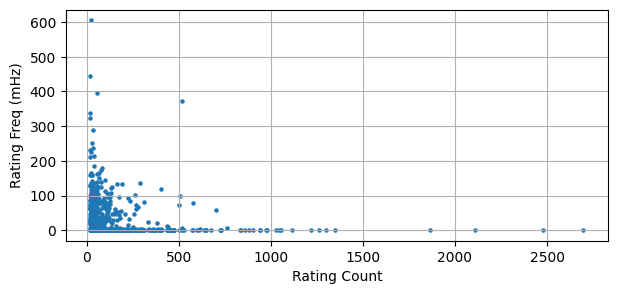

In [21]:
#
# verification frequence de notation par utilisateur
#
def dt_sec(data):
    return data.max() - data.min()

def dt_expanded(data):
    utc_min = datetime.utcfromtimestamp(data.min())
    utc_max = datetime.utcfromtimestamp(data.max())
    dt_full = relativedelta(utc_max, utc_min)
    
    full = []
    if dt_full.years > 0:
        full.append(f"{dt_full.years}y")
    elif dt_full.months > 0:
        full.append(f"{dt_full.months}m")
    elif dt_full.days > 0:
        full.append(f"{dt_full.days}d")
    elif dt_full.hours > 0:
        full.append(f"{dt_full.hours}h")
    else:
        if dt_full.minutes > 0:
            full.append(f"{dt_full.minutes}m")

        if dt_full.seconds > 0:
            full.append(f"{dt_full.seconds}s")
    
    return " ".join(full)

def rating_freq(data):
    num = data.shape[0]
    freq = num / dt_sec(data)
    # mHz pour mieux voir ecarts
    return freq * 1000

user_ratings = mvl_dataset.ratings[["userId", "rating", "timestamp"]] \
                          .groupby(by="userId") \
                          .agg(rating_count=("rating", "count"), 
                               dt_sec=("timestamp", dt_sec),
                               dt_expanded=("timestamp", dt_expanded),
                               rating_freq=("timestamp", rating_freq))

rating_freq_stats = user_ratings.rating_freq.describe().to_frame()
rating_cout_stats = user_ratings.rating_count.describe().to_frame()
fastest_users = user_ratings.nlargest(5, "rating_freq")
slowest_users = user_ratings.nsmallest(5, "rating_freq")

html = jup.horizontify(jup.caption_df(fastest_users.style, 
                                      "Utilisteur les plus rapide", 
                                      caption_bold=False), 
                       jup.caption_df(slowest_users.style, 
                                      "Utilisteur les moins rapide", 
                                      caption_bold=False))
jup.display_html(html)

print()
print("Stats générale")
html = jup.horizontify(rating_freq_stats.style, rating_cout_stats.style)
jup.display_html(html)

#
# visualiser rating_count vs rating_freq
#
def rating_count_vs_freq(user_ratings, critOutliers=None, figsize=(7, 3)):
    plt.figure(figsize=figsize)
    
    if critOutliers is None:
        plt.scatter(user_ratings.rating_count, user_ratings.rating_freq, s=5)
    else:
        outliers = user_ratings[critOutliers]
        plt.scatter(outliers.rating_count, outliers.rating_freq, s=5, label="Outliers")
        
        inliers = user_ratings[~critOutliers]
        plt.scatter(inliers.rating_count, inliers.rating_freq, s=5, label="Inliers")
        
        plt.legend()
    
    plt.grid(True)
    plt.xlabel("Rating Count")
    plt.ylabel("Rating Freq (mHz)")
    plt.show()
    
rating_count_vs_freq(user_ratings)

Les utilisateurs ont votés relativement souvent (20 votes ou plus) mais la distribution est très allongée et fortement concentrée dans les valeurs faibles. Le graphe ci-haut suggère que beaucoup de notations semblent avoir été faites de façon très rapide. Pour illustrer, le user *163* aurait voté 23 fois en 38 secondes (~2 secondes par vote) mais le user *172* aurait pris 1 an pour ses 26 votes. Faute d'informations supplémentaires, nous suspectons un système automatisé et enlevons les utilisateurs ayant une fréquence jugée trop élevée.<br><br>
    
En absolue:
$$
\begin{align}
threshold &= Q_3 + 1.5 * IQR\\
          &= 62.19 + 1.5 * (62.19 - 0.04)\\
          &= 155.36\\
\end{align}
$$
  
Une approche basée sur le *clustering*, plus particulièrement DBSCAN, trouvera les éléments isolés dans le graphe.

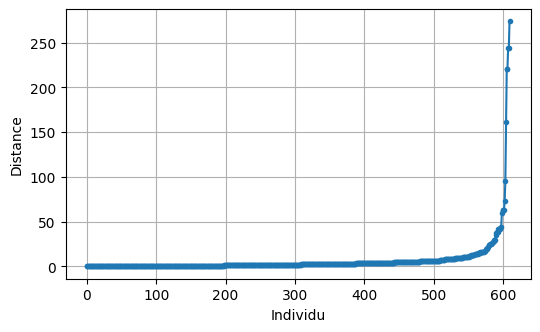

In [22]:
#
# cluster par dbscan pour découvrir les outliers
#
coords = user_ratings[["rating_count", "rating_freq"]]
clstr.dbscan_eps_analysis(coords, figsize=(6, 3.5))

DBSCAN optimal parameters
eps: 45.5
min_samples: 3
silhouette score: 0.7382
# clusters: 4 + ouliers


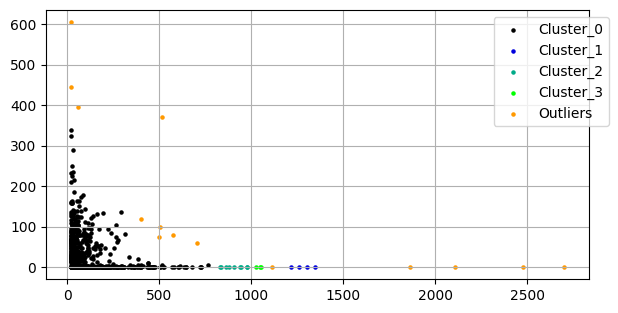

In [23]:
eps_, min_samples_ = clstr.dbscan_parameters_analysis(coords, 
                                                      eps_range=np.arange(30, 50, 0.5),
                                                      min_samples_range=range(2, 20))
dbscan_ = clstr.dbscan_init(coords, eps_, min_samples_)
clstr.show_clusters(coords, 
                    user_ratings.index, 
                    dbscan_.labels_, 
                    figsize=(7, 3.5),
                    text_alpha=0, 
                    marker_size=5)

Nombre de user outliers 28


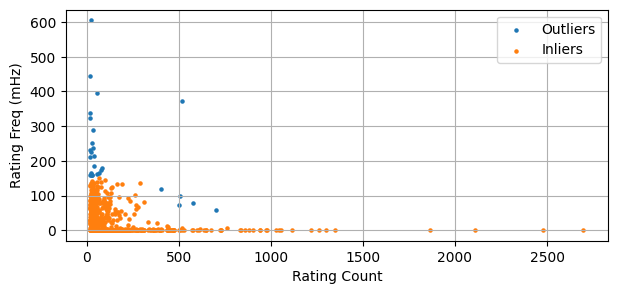

In [24]:
#
# detecter les utilisateurs juges outliers
#
critA = dbscan_.labels_ == -1

# dbscan marque certaines basses frequences 
# s'assurer de les garder
critB = user_ratings.rating_freq > 1

# IQR threshold
critC = user_ratings.rating_freq >= 155.36

# combiner tous les criteres d'outliers
critOutliers = critA & critB | critC

print("Nombre de user outliers", np.count_nonzero(critOutliers))
rating_count_vs_freq(user_ratings, critOutliers)

In [25]:
#
# enlever les utilisateurs juges outliers
#
user_to_remove = user_ratings[critOutliers].index.to_list()
user_to_remove = mvl_dataset.ratings.userId.isin(user_to_remove)
user_to_remove = mvl_dataset.ratings[user_to_remove]

print("ratings avant retrait:", mvl_dataset.ratings.shape[0])
mvl_dataset.ratings.drop(user_to_remove.index, inplace=True, errors="ignore")
print("ratings après retrait:", mvl_dataset.ratings.shape[0])

ratings avant retrait: 100836
ratings après retrait: 96841


Il apparait judicieux d'extraire quelques statistiques sur **rating** afin d'augmenter **movies.csv**.

In [26]:
def mode(ratings):
    # prendre le mode le plus grand
    return ratings.mode().iloc[-1]

def median_keep_category(ratings):
    # garder les modalites de ratings si nombre de valeurs est impaire
    return ratings.quantile(interpolation="nearest")

def join_name(multi_index_name):
    if "" in multi_index_name:
        return multi_index_name[0]
    else:
        return "_".join(multi_index_name)


#
# creer de nouvelles variables
#
ratings_stats = mvl_dataset.ratings[["movieId", "rating"]] \
                           .groupby(by="movieId") \
                           .agg(["count", ("mode", mode), 
                                 "mean", ("median", median_keep_category)])
ratings_stats.columns = [join_name(a) for a in ratings_stats.columns.to_flat_index()]
ratings_stats.reset_index(inplace=True)
print("Rating stats", ratings_stats.shape)
print("Head")
display(ratings_stats.head().round(2))

Rating stats (9461, 5)
Head


,movieId,rating_count,rating_mode,rating_mean,rating_median
0,1,204,4.0,3.91,4.0
1,2,104,4.0,3.43,3.5
2,3,47,3.0,3.27,3.0
3,4,7,3.0,2.36,3.0
4,5,44,3.0,3.02,3.0


In [27]:
#
# valider que ratings_stats contient bien les meme films que movies.csv
#
movies_ratings = pd.merge(mvl_dataset.movies, ratings_stats, how="left", on="movieId")
movies_ratings_na = clstr.show_na(movies_ratings)

Valeur manquante 281 (2.9%)


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
256,295,0114210,"Pyromaniac's Love Story, A (1995)",Comedy|Romance,1995,NaN,NaN,NaN,NaN
258,298,0105652,Pushing Hands (Tui shou) (1992),Drama,1992,NaN,NaN,NaN,NaN
816,1076,0055018,"Innocents, The (1961)",Drama|Horror|Thriller,1961,NaN,NaN,NaN,NaN
1026,1337,0037549,"Body Snatcher, The (1945)",Drama|Horror|Thriller,1945,NaN,NaN,NaN,NaN
1098,1427,0120390,Turbulence (1997),Action|Thriller,1997,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9725,190209,7620650,Jeff Ross Roasts the Border (2017),Comedy,2017,NaN,NaN,NaN,NaN
9726,190213,3977428,John From (2015),Drama,2015,NaN,NaN,NaN,NaN
9727,190215,7293380,Liquid Truth (2017),Drama,2017,NaN,NaN,NaN,NaN
9728,190219,0179011,Bunny (1998),Animation,1998,NaN,NaN,NaN,NaN


Tous les films n'ont pas reçu de notes. Nous pourrions utiliser le web scraping pour déterminer **rating_mean** mais l'échelle sur IMDB n'est pas la même que MovieLens. De plus les autres statistiques ne pourraient pas être extraites. Comme il n'y a que très peu d'éléments manquants, on les ignore.

In [28]:
#
# enlever valeurs manquantes et valider avec shape le resultat
#
print("movies_ratings avant retrait:", movies_ratings.shape)
movies_ratings.drop(index=movies_ratings_na, axis=0, inplace=True, errors="ignore")
print("movies_ratings après retrait:", movies_ratings.shape)

print()

#
# valider les types (drop() peut changer les choses du aux NA)
#
clstr.show_types(movies_ratings)

movies_ratings avant retrait: (9741, 9)
movies_ratings après retrait: (9460, 9)

Types


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
Type,int64,object,object,object,int64,float64,float64,float64,float64


In [29]:
#
# rating_count est en fait un entier, changer son type
#
movies_ratings.rating_count = movies_ratings.rating_count.astype(np.int64)

# Exploration des nouvelles variables

In [30]:
#
# separe quantitatif et qualitatif
#
quant_cols = ["rating_mode", "rating_median", "rating_mean", "rating_count", "year"]
quant_df = movies_ratings[quant_cols]

qual_cols = ["genres"]
qual_df = movies_ratings[qual_cols]

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
rating_mode,9460.0,3.48,0.97,0.5,3.00,3.5,4.00,5.0
rating_median,9460.0,3.22,0.94,0.5,3.00,3.5,4.00,5.0
rating_mean,9460.0,3.24,0.86,0.5,2.77,3.4,3.88,5.0
rating_count,9460.0,10.24,21.77,1.0,1.00,3.0,9.00,319.0
year,9460.0,1994.64,18.38,1902.0,1988.00,1999.0,2008.00,2018.0



Distributions - variables quantitatives


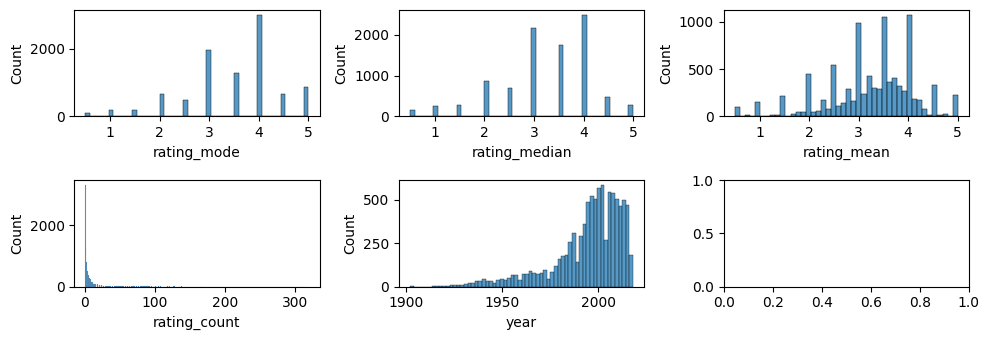

Détails rating_count


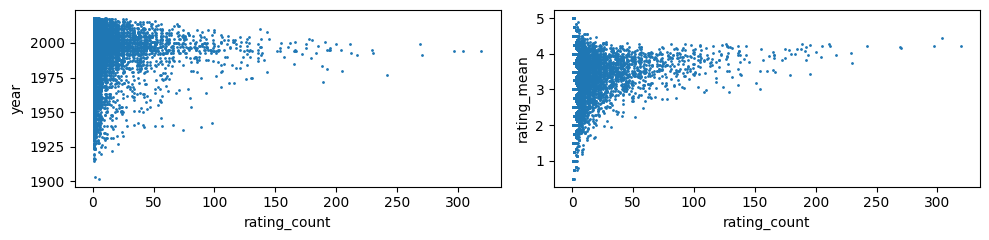

In [31]:
#
# inspection stats et distributions
#
print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=3, figsize=(10, 3.5))

print("Détails rating_count")
plt.figure(figsize=(10, 2.5))

plt.subplot(121)
plt.scatter(quant_df.rating_count, quant_df.year, s=1)
plt.xlabel("rating_count")
plt.ylabel("year")

plt.subplot(122)
plt.scatter(quant_df.rating_count, quant_df.rating_mean, s=1)
plt.xlabel("rating_count")
plt.ylabel("rating_mean")

plt.tight_layout()
plt.show()

<br>**rating_mode**, **rating_median** et **rating_mean**

Distributions très près d'une gaussienne et multimodales (on voit bien l'effet du système de notation). Elles sont aussi très similaires entre elles. La majorité des votes sont entre [3, 4]. Il nous apparait plus juste de choisir **rating_mode** pour représenter la variable **rating**. Elle garde l'aspect qualitatif du système de notation et représente la majorité des utilisateurs. **rating_mean** n'est pas adéquat car il y a peu données par film en général et elles contiennent le spectre complet du domaine.
    
<br>**rating_count**

Les films sont majoritairement notés par peu de personnes. La distribution est très alongée avec un très fort peak dans les valeurs faibles : 75% de la population a moins de 9 votes, 25% n'en a qu'un seul. On pourrait interpréter cette variable comme une mesure de "consensus" sur **rating** mais les 2 derniers graphes montrent bien que ce n'est pas le cas. Les spectres de **year** et **rating** sont couverts. Cette variable sera enlevée.

<br>**year**

Les films sont relativement récents : peak autour de l'an 2000. La base de données couvre un large spectre et la distribution est allongée (queue à gauche).

In [32]:
#
# enlever rating_count, rating_median et rating_mean
#
to_remove = ["rating_count", "rating_median", "rating_mean"]
movies_ratings.drop(to_remove, axis=1, inplace=True, errors="ignore")
quant_df = quant_df.drop(to_remove, axis=1, errors="ignore")

# Valeurs aberrantes et *outliers*

La distribution de **year** pourrait suggérer des valeurs aberrantes. Une inspection manuelle de quelques valeurs via IMDB montre que ces films existent bel et bien même s'ils sont du début du siècle. Les autres variables sont de nature qualitative et sont donc sans valeur aberrante.

La même distribution pourrait également suggérer des *outliers*. Nous allons examiner sa transformation avant de trancher.

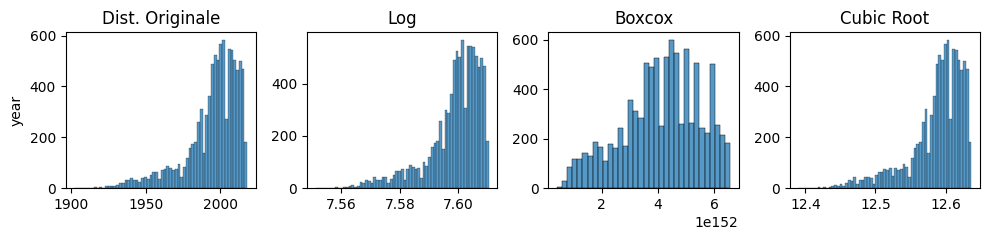

In [33]:
#
# examiner les transformations
#
quant_transformed = clstr.show_transforms(quant_df, 
                                          columns=["year"], 
                                          figsize=(10, 2.5))

* **year** se rapproche d'une distribution gaussienne via boxcox

IQR outliers par variable, eta: 1.5


,year,year_boxcox
Count,562.0,0.0
%,5.9,0.0



IQR outliers 562 (5.9%), eta: 1.5

Outliers boxplots, eta: 1.5


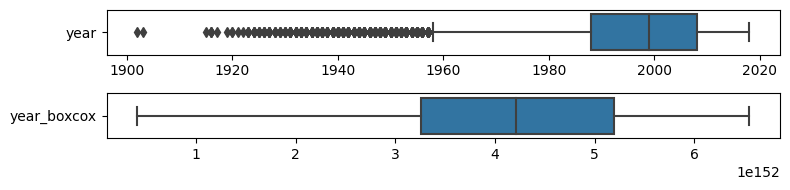

In [34]:
quant_outliers = pd.DataFrame({"year": quant_df.year,
                               "year_boxcox": quant_transformed.boxcox[0].year})
clstr.show_outliers_iqr(quant_outliers, 
                        eta=1.5, 
                        boxlists=[[c] for c in quant_outliers],
                        figsize=(8, 2));

Étant donné le contexte d'un système de suggestions, il nous apparait plus juste de tout garder. Un film des années 50 peut être une meilleure suggestion que certains blockbusters récents. Nous citerons Citizen Kane, War of The Worlds et Vertigo d'Alfred Hitchcock à cet effet. De plus **year_boxcox** enlève tous les outliers.

In [35]:
#
# ajouter year transformee par boxcox
#
# pour faciliter la visualization, mettre year_boxcox pres de year
if "year_boxcox_std" in movies_ratings.columns:
    movies_ratings.pop("year_boxcox_std")
year_index = movies_ratings.columns.to_list().index("year")

# comme year_boxcox est déja transforme et pres d'une distribution gaussienne
# il est plus simple d'appliquer immediatement un standard scaler
year_boxcox = quant_transformed.boxcox[0].year.to_numpy().reshape(-1, 1)
year_boxcox_std = StandardScaler().fit_transform(year_boxcox)

movies_ratings.insert(year_index + 1, "year_boxcox_std", year_boxcox_std)

# Catégorisation

Catégoriser **year** pourrait être intéressant étant donné la nature plutôt qualitative du reste des variables. Nous allons examiner une *clusterization* afin de juger du nombre de catégories. Noter que CAH et KMeans seront les algorithmes utilisés. DBSCAN a besoin d'une analyse sur les distances minimales; hors les années sont systématiquement distantes de 1.

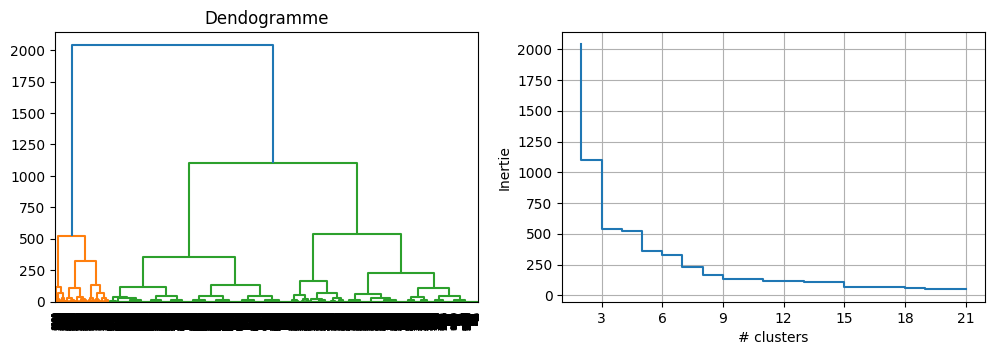

In [36]:
#
# attention, cette operation est longue et sans feedback visuel
#
years_df = movies_ratings.year.to_frame()
clstr.cah_analysis(years_df)

CAH suggère 3 *clusters* (coude vis à vis 3 dans le graphe ci-haut) confirmé sur le dendrogramme par la coupe à la moitié du gain maximum en inertie entre les *clusters*, soit environ 1000, qui donne aussi 3 *clusters* .. Voir plus bas pour visualisation et comparatif.

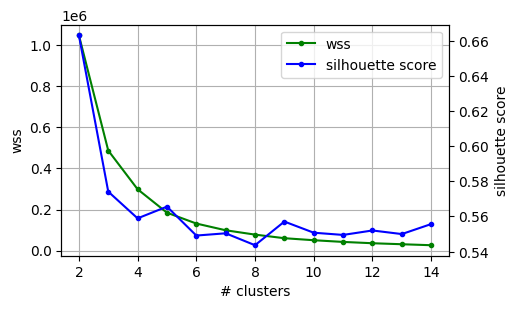

In [37]:
clstr.kmeans_analysis(years_df)

KMeans suggère également 3 clusters (silhouette score maximale et inertie minimale). Voir plus bas pour visualisation et comparatif.


Distribution clusters


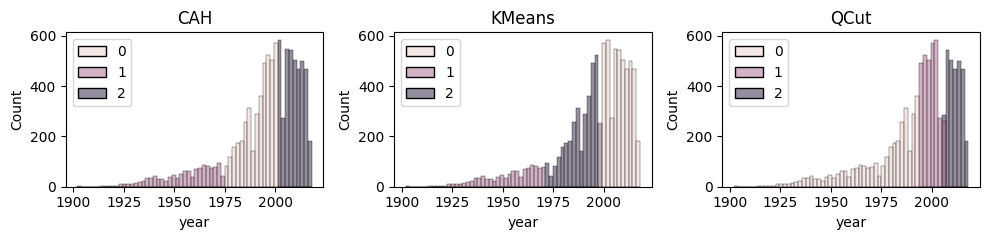

In [38]:
#
# inspection categorisation
#

# etapes
#   1. faire cluster
#   2. trouver intervalles
#   3. formater affichage
#   4. afficher
cah_years = clstr.cah_init(years_df, 3)
cah_intervals = years_df.groupby(cah_years.labels_).agg(["min", "max", "count"])
cah_intervals.index.name = "cluster"
cah_intervals.sort_values(by=("year", "min"), inplace=True)
cah_intervals_styl = jup.caption_df(cah_intervals.style, 
                                    "CAH intervalles", 
                                    caption_bold=False)

kmeans_years = clstr.kmeans_init(years_df, 3)
kmeans_intervals = years_df.groupby(kmeans_years.labels_).agg(["min", "max", "count"])
kmeans_intervals.index.name = "cluster"
kmeans_intervals.sort_values(by=("year", "min"), inplace=True)
kmeans_intervals_styl = jup.caption_df(kmeans_intervals.style, 
                                       "KMeans intervalles", 
                                       caption_bold=False)

# division en tiertile etant donne que nous avons 3 clusters
qcut_years = pd.qcut(years_df.year, [0, 1/3, 2/3, 1.0], labels=[0, 1, 2])
qcut_intervals = years_df.groupby(qcut_years).agg(["min", "max", "count"])
qcut_intervals.index.name = "cluster"
qcut_intervals.sort_values(by=("year", "min"), inplace=True)
qcut_intervals_styl = jup.caption_df(qcut_intervals.style, 
                                     "QCut intervalles", 
                                     caption_bold=False)


html_ = jup.horizontify(cah_intervals_styl, 
                        kmeans_intervals_styl, 
                        qcut_intervals_styl)
jup.display_html(html_)

print()

print("Distribution clusters")
plt.figure(figsize=(10, 2.5))
plt.subplot(131)
sns.histplot(x="year",
             data=movies_ratings, 
             hue=cah_years.labels_, 
             ax=plt.gca())
plt.title("CAH")

plt.subplot(132)
sns.histplot(x="year",
             data=movies_ratings, 
             hue=kmeans_years.labels_, 
             ax=plt.gca())
plt.title("KMeans")

plt.subplot(133)
sns.histplot(x="year",
             data=movies_ratings, 
             hue=qcut_years.to_numpy(), 
             ax=plt.gca())
plt.title("QCut")

plt.tight_layout()
plt.show()

CAH et KMeans suggèrent 3 *clusters*. L'inspection visuelle de ceux-ci nous apparait correcte quant au choix d'intervalles mais les comptes montrent un débalancement. Les intervalles de QCut ne semblent pas bien représenter la distribution de **year** bien qu'étant balancés.

CAH nous semblent le meilleur compromis. En effet, 2 des 3 *clusters* sont bien balancés et les intervalles représentent bien la distribution de **year**. Le choix de garder ou non le *cluster* "problématique" pourra être fait lors de l'implémentation du système de suggestions. Noter qu'il représente environ 13% (1231 / 9460) des données et coïncide relativement bien avec l'analyse des *outliers* faite plus haut.

In [39]:
#
# ajout categorisation sur year
#
# pour faciliter la visualization, mettre year_category pres de year
if "year_category" in movies_ratings.columns:
    movies_ratings.pop("year_category")
year_index = movies_ratings.columns.to_list().index("year")

# transformer numero de cluster en intervalle
def cluster_to_label(c):
    min_ = cah_intervals.loc[c, ("year", "min")]
    max_ = cah_intervals.loc[c, ("year", "max")]
    return f"[{min_}, {max_}]"
year_category_labels = np.vectorize(cluster_to_label)(cah_years.labels_)
movies_ratings.insert(year_index + 1, "year_category", year_category_labels)

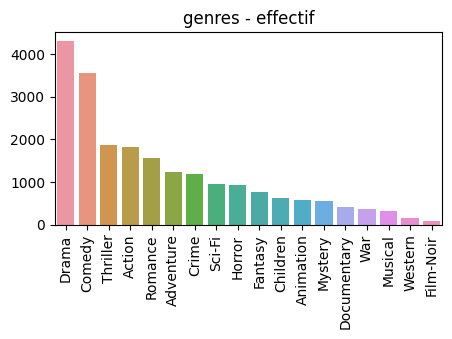

In [40]:
#
# examiner variables qualitatives
#
genres_ohe_df = qual_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
genres_count = genres_ohe_df.sum(axis=0)

genres_df = pd.Series(genres_count,
                      index=genres_count.index,
                      name="count")
genres_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(5, 2.5))
sns.barplot(x=genres_df.index, y=genres_df.values, ax=plt.gca())
plt.tick_params(axis="x", labelrotation=90)
plt.title("genres - effectif")
plt.show()

* Forte proportion dans Drama et Comedy
* Les modalités sont débalancées

Afin de mitiger le débalancement, il pourrait être judicieux d'appliquer une transformation de type TF-IDF (term frequency-inverse document frequency). En effet, le problème de *clusterization* par genre a des similarités avec le traitement de documents dans un contexte de NLP.

In [50]:
#
# transformation tf-idf
#
genres_tf_idf = TfidfTransformer().fit_transform(genres_ohe_df)
genres_tf_idf_df = pd.DataFrame.sparse.from_spmatrix(genres_tf_idf, 
                                                     index=genres_ohe_df.index,
                                                     columns=genres_ohe_df.columns)
# se garder une copie avec les noms des colonnes non modifiees
genres_tf_idf_vanilla_df = genres_tf_idf_df.copy()
genres_tf_idf_df.columns = [f"genres_tfidf_{c}" for c in genres_tf_idf_df.columns]

# validaton par inspection visuelle
print("genres tf-idf:", genres_tf_idf_df.shape)
print("HEAD")
display(genres_tf_idf_df.head())

genres tf-idf: (9460, 18)
HEAD


,genres_tfidf_Action,genres_tfidf_Adventure,genres_tfidf_Animation,genres_tfidf_Children,genres_tfidf_Comedy,genres_tfidf_Crime,genres_tfidf_Documentary,genres_tfidf_Drama,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
0,0.0,0.413531,0.51858,0.506535,0.269500,0.0,0.0,0.000000,0.480478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.509622,0.00000,0.624238,0.000000,0.0,0.0,0.000000,0.592126,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,0.576516,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.817086,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.00000,0.000000,0.511112,0.0,0.0,0.462626,0.000000,0.0,0.0,0.0,0.0,0.724390,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Distributions genres tf-idf


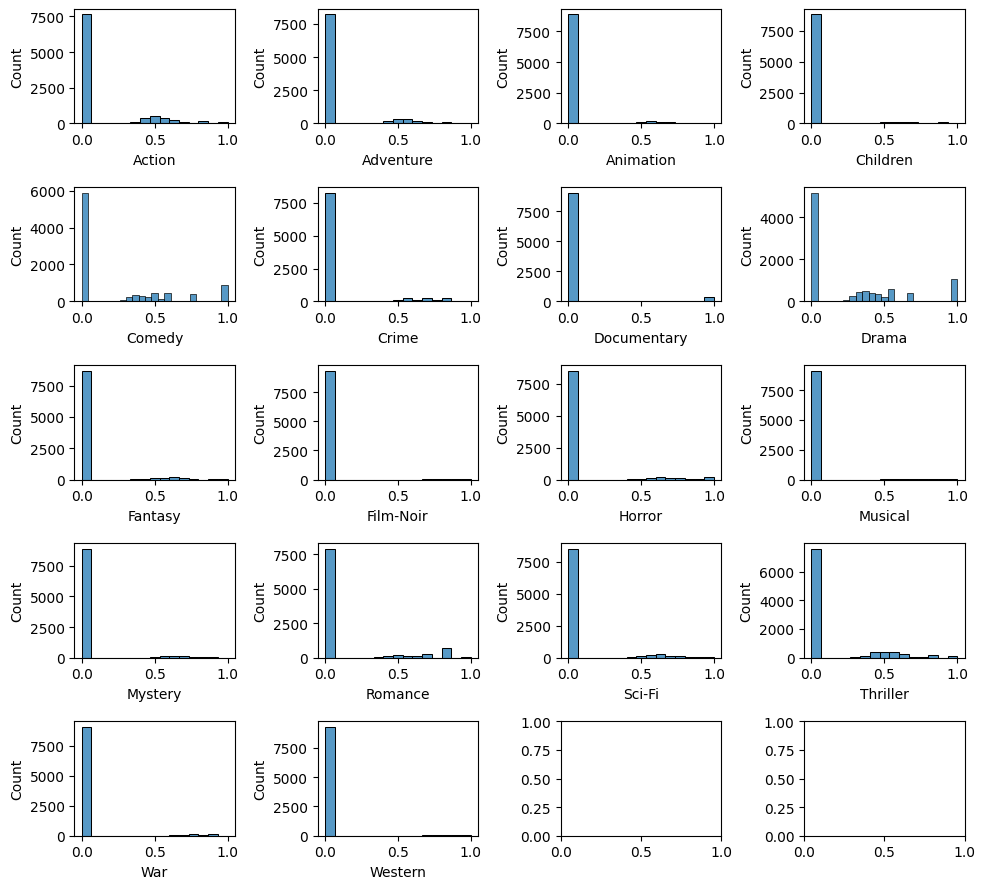

In [42]:
print("Distributions genres tf-idf")
clstr.show_distributions(genres_tf_idf_vanilla_df, 
                         num_cols=4, 
                         figsize=(10, 9))

IQR outliers par variable, eta: 1.5


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Count,61.0,56.0,27.0,0.0,0.0,2.0,91.0,0.0,4.0,2.0,0.0,0.0,5.0,0.0,39.0,81.0,0.0,1.0
%,0.6,0.6,0.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.9,0.0,0.0



IQR outliers 363 (3.8%), eta: 1.5

Outliers boxplots, eta: 1.5


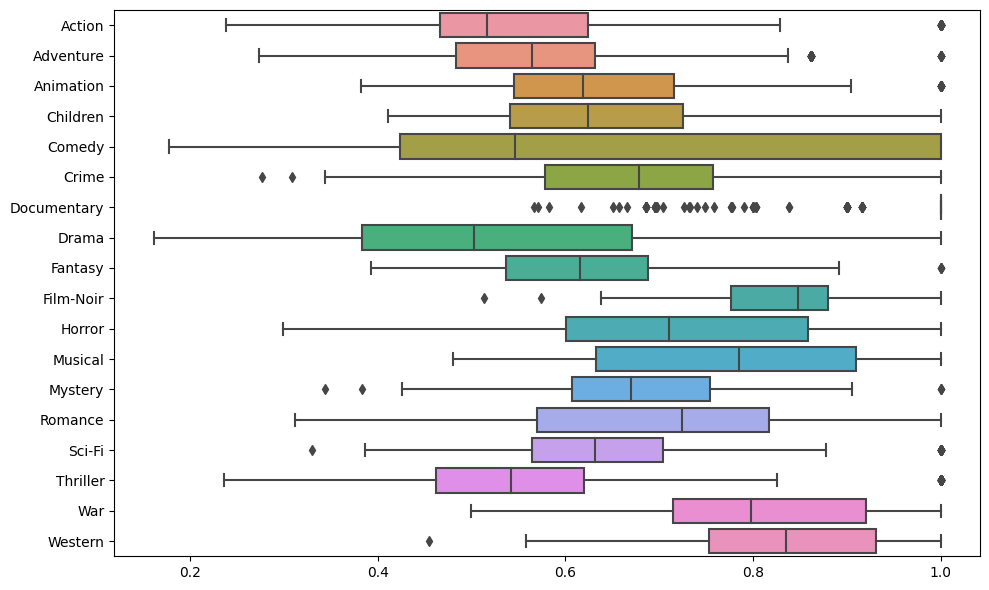

In [43]:
#
# retirer les 0 pour visualiser les genres_tfidf*
#
data_tmp = genres_tf_idf_vanilla_df.sparse.to_dense()
data_tmp = data_tmp[data_tmp > 0]
clstr.show_outliers_iqr(data_tmp,
                        eta=1.5,
                        boxlists=[data_tmp.columns],
                        figsize=(10, 6));


Les distributions sont très éparses (beaucoup de 0). Ceci est attendu de part la nature des données. Noter que la transformation one hot ne sera pas ajoutée car elle ajoute beaucoup de redondance d'informations.

**genres_tfidf\*** ne possède pas d'*outliers* à notre avis de part sa nature éparse. Les 0 marquent l'absence du genre dans certains films. Les 1 marquent quant à eux la présence d'un seul genre dans les films.

In [44]:
#
# ajouter tf-idf
#
# pour faciliter la visualization, mettre genre et tf-idf a la fin
if "genres" in movies_ratings.columns:
    movies_ratings["genres"] = movies_ratings.pop("genres")
movies_final_df = pd.concat([movies_ratings, genres_tf_idf_df], axis=1)

# validation par inspection de shape
print(movies_final_df.shape)

(9460, 26)


In [45]:
#
# sauvegarde des traitements fait sur movies
#
csv_path = mvl_dataset.movies_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
movies_final_df.to_csv(csv_path, index=False)

Sauvegarde dataset/movies_pretraitement.csv


# Collaborative filtering

Les systèmes de suggestions se basent souvent sur 2 composantes : content base et collaborative filtering. L'idée étant d'utiliser l'historique de plusieurs utilisateurs (collaborative filtering) et à défaut de l'avoir, utiliser seulement le contenu des films (content base filtering). Nous colligerons l'information de **ratings.csv** afin de couvrir cet aspect. Noter que tous les traitements (valeurs manquantes, aberrantes(outliers)) sont déjà faits à ce point-ci.

In [46]:
#
# s'assurer de garder uniquement les utilisateurs qui ont
# les movieId presents dans movies_ratings
#
movieIds = movies_ratings.movieId.unique()
ratings = mvl_dataset.ratings[ mvl_dataset.ratings.movieId.isin(movieIds)  ]

user_ratings = ratings \
                .pivot(index="userId", columns="movieId", values="rating") \
                .reset_index()
user_ratings.columns.name = ""

print("User ratings:", user_ratings.shape)
print("HEAD")
display(user_ratings.head())

User ratings: (582, 9461)
HEAD


,userId,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Données très éparses et de très grande dimensionalité. Ceci est attendu étant donné la nature du problème. Enlever les valeurs manquantes n'est pas possible puisque la majorité des données seraient perdues.

In [47]:
#
# sauvegarde des traitements sur user_ratings
#
csv_path = mvl_dataset.ratings_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
user_ratings.to_csv(csv_path, index=False)

Sauvegarde dataset/ratings_pretraitement.csv


# Corrélations

Résumé des variables produites :

* **year**
* **year_boxcox_std**
* **year_category**
* **genres**
* **genres_tfidf**
* **rating_mode**

Les tuples suivants nous apparaissent les plus adéquats dans le contexte de suggestions de films via *clusterization* :

* (**year_category**, **genres**)
* (**year_category**, **rating_mode**)
* (**genres**, **rating_mode**)
* (**genres_tfidf**)

Par conséquent, l'analyse de corrélation ne retiendra que les variables qualitatives et **genres_tfidf** à part. La métrique utilisée sera $\chi^2$ (chi carré). **year** et **year_boxcox_std** sont tout de même laissées dans le fichier final afin que le prochain utilisateur puisse en bénéficier. 

In [48]:
def genres_contingency(b, data, genres_set):
    def _genres_crit(data, modality):
        return data.str.contains(fr"\b{modality}\b", case=True, regex=True)
    
    def _default_crit(data, modality):
        return data == modality

    if b == "genres":
        other_crit_ = _genres_crit
        other = data.genres
        other_modalities = list(genres_set)
    else:
        other_crit_ = _default_crit
        other = data[b]
        other_modalities = other.unique()
    
    ct = pd.DataFrame(0, 
                      index=list(genres_set), 
                      columns=other_modalities)

    for m0 in genres_set:
        genres_crit = _genres_crit(data.genres, m0)
        
        for m1 in other_modalities:
            other_crit = other_crit_(other, m1)
            ct.loc[m0, m1] = np.count_nonzero(genres_crit & other_crit)
        
    return ct

def chi2(a, b, df, genres_set):
    if a == "genres":
        contingency = genres_contingency(b, df, genres_set)
    elif b == "genres":
        contingency = genres_contingency(a, df, genres_set).T
    else:
        contingency = pd.crosstab(df[a], df[b])
    chi2_, pvalue, _, _ = chi2_contingency(contingency)
    return chi2_, pvalue

chi2_columns = ["year_category", "rating_mode", "genres"]
genres_set = set()
movies_final_df \
    .genres \
    .str \
    .split(configs.dataset.genre_splitter) \
    .agg(lambda genres: genres_set.update(genres))

chi2_df = pd.DataFrame(np.nan, 
                       index=chi2_columns, 
                       columns=chi2_columns)
chi2_pvalue_df = pd.DataFrame(np.nan, 
                              index=chi2_columns, 
                              columns=chi2_columns)

for c0 in chi2_columns:
    for c1 in chi2_columns:
        prev = chi2_df.loc[c1, c0]
        
        if math.isnan(prev):
            prev, prev_pvalue = chi2(c0, 
                                     c1, 
                                     movies_final_df,
                                     genres_set)
        else:
            prev_pvalue = chi2_pvalue_df.loc[c1, c0]

        chi2_df.loc[c0, c1] = prev
        chi2_pvalue_df.loc[c0, c1] = prev_pvalue

chi2_styler = jup.caption_df(chi2_df.style, 
                             "$\chi^2$", 
                             caption_bold=False)
pvalue_styler = jup.caption_df(chi2_pvalue_df.style, 
                               "$p_{value}$", 
                               caption_bold=False)

corr_html = jup.horizontify(chi2_styler, pvalue_styler)
print("Analyse indépendance de:", chi2_columns)
jup.display_html(corr_html)

Analyse indépendance de: ['year_category', 'rating_mode', 'genres']


,year_category,rating_mode,genres
year_category,18920.000000,849.911482,934.048473
rating_mode,849.911482,85140.000000,801.501340
genres,934.048473,801.501340,134711.974950
,year_category,rating_mode,genres
year_category,0.000000,0.000000,0.000000
rating_mode,0.000000,0.000000,0.000000
genres,0.000000,0.000000,0.000000


On voit que $p_{value}$ est < 0.05. On rejète l'hypothèse nulle (indépendance). Les variables sont donc dépendantes.

Corrélation genres tfidf


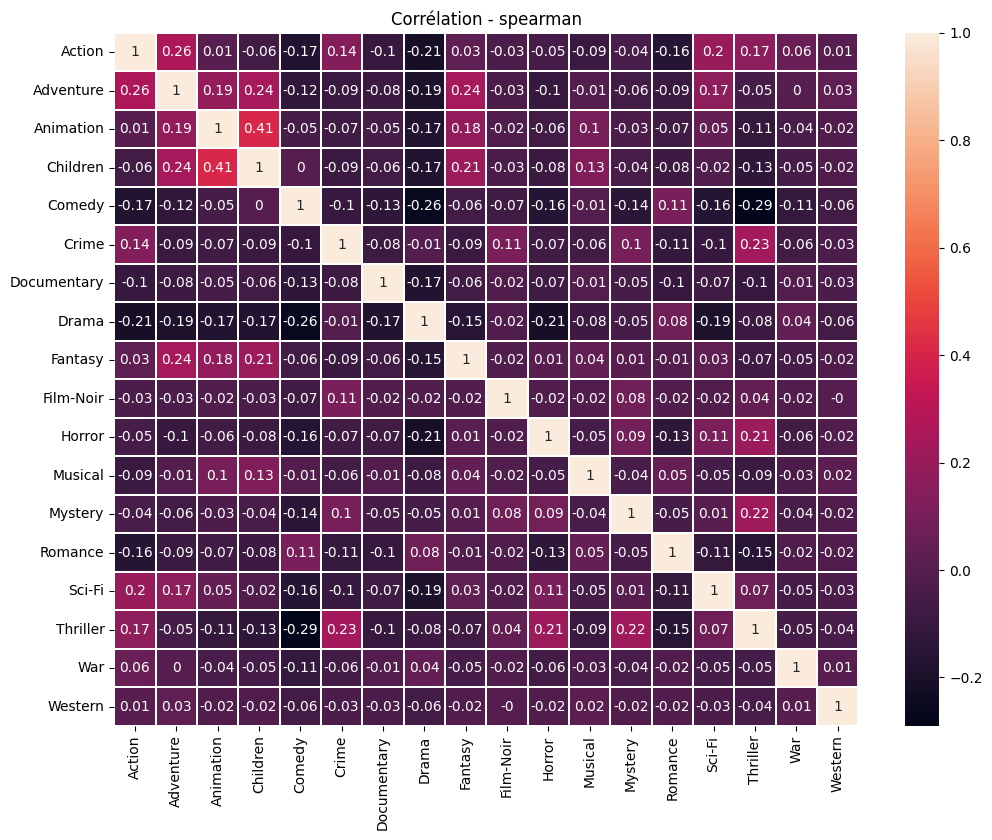

In [49]:
print("Corrélation genres tfidf")
clstr.show_correlation(genres_tf_idf_vanilla_df, 
                       method="spearman", 
                       figsize=(12, 9))

On observe aucune corrélation à toute fin pratique (majorités des valeurs < |0.2|). 

Noter que certaines modalités semblent exhiber un lien entre elles. Children et Animation par exemple. Bien que non montré dans ce notebook, nous avons tenté d'en éliminier quelques unes. Nous avons rencontré un phénomène en cascade qui éliminait les films beaucoup plus rapidement que le retrait des modalités. Nous avons donc tout gardé.

# Suggestion méthode d’apprentissage

### Content base

Nous suggérons d'emblée une ACM pour réduire la dimentionalité parce que la grande majorités de nos variables sont qualitatives. Si **rating_mode** demeurait quantitatif, nous suggérerions une AFDM avec un avertissement sur **genres**. En effet, sa grande dimentionalité et sa nature "multimodale" pourrait influencer les résultats. Pour aller au delà du système de suggestions, **year_boxcox_std** pourrait être inclu dans l'AFDM. **year_category** pourrait servir à diviser les données en sous groupes et chacun de ceux-ci pourrait être à son tour traité indépendement. 

Si uniquement **genres** est ciblé, nous suggérerions d'utiliser **genres_tfidf** à la place. Le débalancement des modalités et la nature "multimodale" nous apparaît comme mieux capturé. Une réduction de dimensionalité via PCA ne serait pas recommendée dû à la présence de beaucoup de 0. Une méthode telle que [TruncatedSVD](https://tinyurl.com/578bxnnt) nous apparait plus adéquate car elle accepte les valeurs manquantes (les 0). Une autre possibilité serait de construire la matrice des distances avec [sklearn.metrics.pairwise_distances](https://tinyurl.com/255b79br) et une métrique telle que *cosine* ou *hamming* (mesure de similarité). Celle-ci serait injectée dans CAH ou DBSCAN (metric="precomputed"). La visualisation pourrait se faire par [tSNE](https://tinyurl.com/2yh92jxc) ou [MDS](https://tinyurl.com/32u5nx9n). 


### Collaborative filtering

La méthode d'apprentissage suggérée est [Singular Value Decomposition](https://tinyurl.com/4emrd5ej) (SVD). Plus particulièrement TruncatedSVD pour gérer les valeurs manquantes. L'idée générale est de factoriser une matrice de tel sorte que $C = U~\Sigma~V$. Si les rangées de $C$ représentent des utilisateurs, les colonnes des produits et les valeurs des notations, alors les rangées de $U$ représentent des utilisateurs, les colonnes l'espace réduit, les rangées de $V$ représentent des produits et les colonnes l'espace réduit. 

![SVD](./images/SVD.png)

Il sera donc possible de trouver des similarités entre utilisateurs et produits dans l'espace réduit et par conséquent des suggestions. Plutôt intriguant comme similarité avec notre problème vous ne trouvez pas?

Les limites de la technique ne nous sont pas famililères mais il apparait évident que la quantité de valeurs manquantes est un facteur déterminant. Dans notre dataset, nous avons au moins 20 notations par utilisateur. L'expérimentation pourrait valider si c'est suffisant.